In [1]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 95.9 MB/s eta 0:00:00


In [2]:
# Bibliothèques standard
import os, requests, zipfile

# Data science et manipulation de données
import pandas as pd, numpy as np, geopandas as gpd

# Accès S3
import s3fs


# Fonctions et styles personnalisés importés de visualisation.py
from visualisation import (
    charte_graphique,
    charte_graphique2,
    charte_graphique3,
    dictionnaire_geo,
    tracer_evolution_taux,
    tracer_evolution_taux_relatif_lisse,
    boxplot_indicateur_par_saison,
    evolution_indicateur_animation,
    animer_evolution_densite,
    evolution_idf_animation,
    get_increase,
    tri_occurrence,
    plot_histogram,
    camembert,
    nb_lignes_traitant,
    filter_rows_with_keyword,
    count_crime_keywords,
    évolution_indicateur,
    évolution_indicateur,
)

ImportError: cannot import name 'nb_lignes_traitant' from 'visualisation' (/home/onyxia/work/Python-pour-la-data-science-2A/visualisation.py)

In [3]:
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "anhlinh"

FILE_PATH_S3_DEP = f"{MY_BUCKET}/diffusion/df_indicateurs_dep.csv"
with fs.open(FILE_PATH_S3_DEP, "rb") as file_in_dep:
    df_indicateurs_dep = pd.read_csv(file_in_dep)


FILE_PATH_S3_LODA = f"{MY_BUCKET}/diffusion/df_loda.csv"
with fs.open(FILE_PATH_S3_LODA, "rb") as file_in_loda:
    df_loda = pd.read_csv(file_in_loda)

FILE_PATH_S3_NAT = f"{MY_BUCKET}/diffusion/df_indicateurs_nat.csv"
with fs.open(FILE_PATH_S3_NAT, "rb") as file_in_nat:
    df_indicateurs_nat = pd.read_csv(file_in_nat)


In [4]:
df_loda_reg = df_loda.drop([ "Unnamed: 0", "ID", "Date", "Nature", "Etat", "Origine", "Date Publication", "Mois"], axis = 1)
df_loda_reg.head()

,Titre,Année
0,Arrêté du 31 décembre 2008 relatif aux modalit...,2009
1,Arrêté du 31 décembre 2008 portant création d'...,2009
2,Décret n° 2008-1549 du 31 décembre 2008 portan...,2009
3,Arrêté du 31 décembre 2008 relatif aux modalit...,2009
4,Arrêté du 31 décembre 2008 relatif aux modalit...,2009


In [5]:
print(len(df_loda_reg))
df_loda_filtre = df_loda_reg[df_loda_reg["Titre"].str.contains(r"\bvols?\b", case=False, na=False)]
print(len(df_loda_filtre))

15541
231


In [6]:
df_loda_reg_filtre = df_loda_filtre.groupby("Année").size().reset_index(name="Nombre d'articles")
print(df_loda_reg_filtre)

    Année  Nombre d'articles
0    1997                  5
1    1998                  3
2    1999                  2
3    2000                  2
4    2001                 13
5    2002                  4
6    2004                  9
7    2005                 11
8    2006                  6
9    2008                 30
10   2009                 13
11   2010                  3
12   2011                 15
13   2012                 10
14   2013                 19
15   2014                  8
16   2015                  4
17   2016                  9
18   2017                 13
19   2018                  8
20   2019                  3
21   2020                  5
22   2021                  6
23   2022                 30


In [7]:
df_indicateurs_reg = df_indicateurs_dep.drop([ "Unnamed: 0", "Superficie (km2)", "Nombre" , "Département"], axis = 1)
df_indicateurs_reg = df_indicateurs_reg[df_indicateurs_reg["Indicateur"] == "Vols sans violence"]
df_indicateurs_reg.head()

,Année,Indicateur,Population,Taux (/10 000),Nom Département,Densité
12960,1996,Vols sans violence,499310,242.494643,Ain,86.655675
12961,1996,Vols sans violence,538017,319.878368,Aisne,73.080277
12962,1996,Vols sans violence,349376,280.099377,Allier,47.598910
12963,1996,Vols sans violence,137453,353.066139,Alpes-de-Haute-Provence,19.848809
12964,1996,Vols sans violence,118526,321.954677,Hautes-Alpes,21.359885


In [8]:
df_indicateurs_nat.head()
df_indicateurs_nat_reg = df_indicateurs_nat.loc[: ,["Année", "Taux de pauvreté (%)"]]
df_pauvrete_percent = df_indicateurs_nat_reg.drop_duplicates()
print(df_pauvrete_percent)

     Année  Taux de pauvreté (%)
0     1996                  19.3
12    1997                  18.8
24    1998                  18.4
36    1999                  17.9
48    2000                  18.0
60    2001                  17.2
72    2002                  16.6
84    2003                  18.4
96    2004                  18.0
108   2005                  18.8
120   2006                  18.0
132   2007                  18.2
144   2008                  18.5
156   2009                  19.0
168   2010                  18.9
180   2011                  19.2
192   2012                  20.5
204   2013                  20.0
216   2014                  20.2
228   2015                  19.7
240   2016                  19.7
252   2017                  19.5
264   2018                  19.6
276   2019                  19.7
288   2020                  18.6
300   2021                  20.2
312   2022                  19.3


In [12]:
df_pauvrete_loda_nbr= pd.merge(df_pauvrete_percent, df_loda_reg_filtre, on="Année", how="outer")
df_reg =pd.merge(df_pauvrete_loda_nbr, df_indicateurs_reg, on = "Année", how = "outer")
print(df_reg)

      Année  Taux de pauvreté (%)  Nombre d'articles          Indicateur  \
0      1996                  19.3                NaN  Vols sans violence   
1      1996                  19.3                NaN  Vols sans violence   
2      1996                  19.3                NaN  Vols sans violence   
3      1996                  19.3                NaN  Vols sans violence   
4      1996                  19.3                NaN  Vols sans violence   
...     ...                   ...                ...                 ...   
2587   2022                  19.3               30.0  Vols sans violence   
2588   2022                  19.3               30.0  Vols sans violence   
2589   2022                  19.3               30.0  Vols sans violence   
2590   2022                  19.3               30.0  Vols sans violence   
2591   2022                  19.3               30.0  Vols sans violence   

      Population  Taux (/10 000)          Nom Département      Densité  
0         4993

In [13]:
colonne_a_mettre_en_premier = "Nom Département"
colonnes = [colonne_a_mettre_en_premier] + [col for col in df_reg.columns if col != colonne_a_mettre_en_premier]
df_reg = df_reg[colonnes]
df_reg["Nombre d'articles"] = df_reg["Nombre d'articles"].fillna(0)
df_reg = df_reg.drop(["Indicateur"], axis = 1)
print(df_reg)

              Nom Département  Année  Taux de pauvreté (%)  Nombre d'articles  \
0                         Ain   1996                  19.3                0.0   
1                       Aisne   1996                  19.3                0.0   
2                      Allier   1996                  19.3                0.0   
3     Alpes-de-Haute-Provence   1996                  19.3                0.0   
4                Hautes-Alpes   1996                  19.3                0.0   
...                       ...    ...                   ...                ...   
2587                  Essonne   2022                  19.3               30.0   
2588           Hauts-de-Seine   2022                  19.3               30.0   
2589        Seine-Saint-Denis   2022                  19.3               30.0   
2590             Val-de-Marne   2022                  19.3               30.0   
2591               Val-d'Oise   2022                  19.3               30.0   

      Population  Taux (/10

In [16]:
df_reg = df_reg.set_index(['Nom Département', 'Année'])

In [17]:
df_reg

,,Taux de pauvreté (%),Nombre d'articles,Population,Taux (/10 000),Densité
Nom Département,Année,,,,,
Ain,1996,19.3,0.0,499310,242.494643,86.655675
Aisne,1996,19.3,0.0,538017,319.878368,73.080277
Allier,1996,19.3,0.0,349376,280.099377,47.598910
Alpes-de-Haute-Provence,1996,19.3,0.0,137453,353.066139,19.848809
Hautes-Alpes,1996,19.3,0.0,118526,321.954677,21.359885
...,...,...,...,...,...,...
Essonne,2022,19.3,30.0,1319836,172.347170,731.616408
Hauts-de-Seine,2022,19.3,30.0,1641277,236.248970,9325.437500
Seine-Saint-Denis,2022,19.3,30.0,1679240,255.401253,7115.423729


In [18]:
import pandas as pd
from linearmodels.panel import PanelOLS

# Définir la variable dépendante et les variables explicatives
y = df_reg['Taux (/10 000)']
X = df_reg[["Taux de pauvreté (%)", "Nombre d'articles", "Population", "Densité"]]

# Ajouter une constante pour l'interception
from statsmodels.api import add_constant
X = add_constant(X)

# Modèle de régression pour données de panel
model = PanelOLS(y, X, entity_effects=True)  # entity_effects=True pour inclure les effets fixes des départements

# Ajuster le modèle
results = model.fit()

# Résultats
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:         Taux (/10 000)   R-squared:                        0.5961
Estimator:                   PanelOLS   R-squared (Between):             -23.703
No. Observations:                2592   R-squared (Within):               0.5961
Date:                Sat, Dec 28 2024   R-squared (Overall):             -15.781
Time:                        17:54:45   Log-likelihood                -1.365e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      919.45
Entities:                          96   P-value                           0.0000
Avg Obs:                       27.000   Distribution:                  F(4,2492)
Min Obs:                       27.000                                           
Max Obs:                       27.000   F-statistic (robust):             919.45
                            

In [19]:
# Prédictions du modèle
df_reg['Predicted'] = results.predict().fitted_values

In [20]:
df_reg

,,Taux de pauvreté (%),Nombre d'articles,Population,Taux (/10 000),Densité,Predicted
Nom Département,Année,,,,,,
Ain,1996,19.3,0.0,499310,242.494643,86.655675,416.300913
Aisne,1996,19.3,0.0,538017,319.878368,73.080277,384.167939
Allier,1996,19.3,0.0,349376,280.099377,47.598910,542.918699
Alpes-de-Haute-Provence,1996,19.3,0.0,137453,353.066139,19.848809,721.241874
Hautes-Alpes,1996,19.3,0.0,118526,321.954677,21.359885,737.074509
...,...,...,...,...,...,...,...
Essonne,2022,19.3,30.0,1319836,172.347170,731.616408,-339.977907
Hauts-de-Seine,2022,19.3,30.0,1641277,236.248970,9325.437500,-810.964136
Seine-Saint-Denis,2022,19.3,30.0,1679240,255.401253,7115.423729,-790.974382


In [21]:

# Calculer les résidus pour analyse ultérieure si nécessaire
df_reg['Residuals'] = df_reg['Taux (/10 000)'] - df_reg['Predicted']

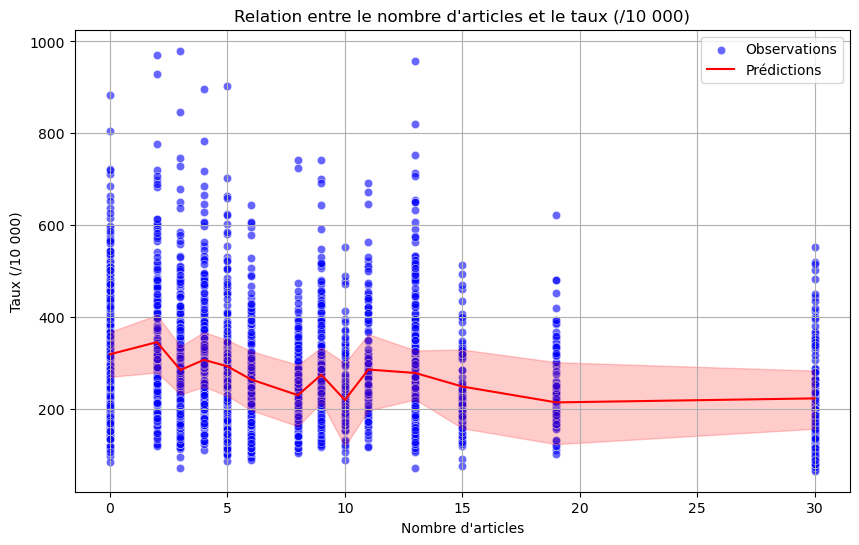

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Points observés
sns.scatterplot(
    x=df_reg['Nombre d\'articles'], 
    y=df_reg['Taux (/10 000)'], 
    color='blue', 
    alpha=0.6, 
    label='Observations'
)

# Ligne de prédictions
sns.lineplot(
    x=df_reg["Nombre d'articles"], 
    y=df_reg['Predicted'], 
    color='red', 
    label='Prédictions'
)

# Ajouter des étiquettes et une légende
plt.title("Relation entre le nombre d'articles et le taux (/10 000)")
plt.xlabel("Nombre d'articles")
plt.ylabel("Taux (/10 000)")
plt.legend()
plt.grid(True)
plt.show()
